# Image classification using VGG16

In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

### Load Dataset

In [3]:
CLASS_LABEL_MAP = {'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}

In [4]:
def load_dataset():
    # directory paths
    img_dir = "Dataset/images"
    ann_dir = "Dataset/annotations"

    images = []
    labels = []

    for img_name in os.listdir(img_dir):
        # Load image
        img_path = os.path.join(img_dir, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image) # Normalize for VGG16

        # Load corresponding annotation
        ann_path = os.path.join(ann_dir, img_name.replace('.png', '.xml'))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        label = root.find("object").find("name").text  # Extract object label

        images.append(image)
        labels.append(CLASS_LABEL_MAP[label]) # Convert string label to numeric

    return np.array(images), np.array(labels)

In [6]:
X, y = load_dataset()

In [7]:
X.shape, y.shape

((877, 224, 224, 3), (877,))

### Train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_test.shape

((701, 224, 224, 3), (176, 224, 224, 3))

### Model Training

In [10]:
# Model definition

vgg16_model = Sequential()

pretrained_model = VGG16(
    include_top=False,
    input_shape = (224, 224, 3),
    pooling='avg',
    classes=4,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable=False

vgg16_model.add(pretrained_model)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(Dense(4, activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [11]:
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Model training
history = vgg16_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6855 - loss: 2.9804 - val_accuracy: 0.8068 - val_loss: 0.7586
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9333 - loss: 0.2369 - val_accuracy: 0.8636 - val_loss: 0.6212
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9435 - loss: 0.1238 - val_accuracy: 0.8409 - val_loss: 0.6548
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9750 - loss: 0.0587 - val_accuracy: 0.8409 - val_loss: 0.6424
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9826 - loss: 0.0555 - val_accuracy: 0.8295 - val_loss: 0.8923


### Model Evaluation

In [15]:
# Test accuracy
vgg16_model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.8212 - loss: 0.9714


[0.8923488259315491, 0.8295454382896423]

In [16]:
y_predicted = vgg16_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step


In [17]:
# Converting probabilities to discrete integers
y_predicted = [np.argmax(element) for element in y_predicted]
y_predicted[:5]

[1, 2, 1, 2, 1]

In [18]:
print(classification_report(y_test, y_predicted, target_names=CLASS_LABEL_MAP.keys()))

              precision    recall  f1-score   support

   crosswalk       0.83      0.45      0.59        22
  speedlimit       0.83      0.97      0.90       120
        stop       0.87      0.59      0.70        22
trafficlight       0.75      0.50      0.60        12

    accuracy                           0.83       176
   macro avg       0.82      0.63      0.70       176
weighted avg       0.83      0.83      0.81       176



Text(45.722222222222214, 0.5, 'Truth')

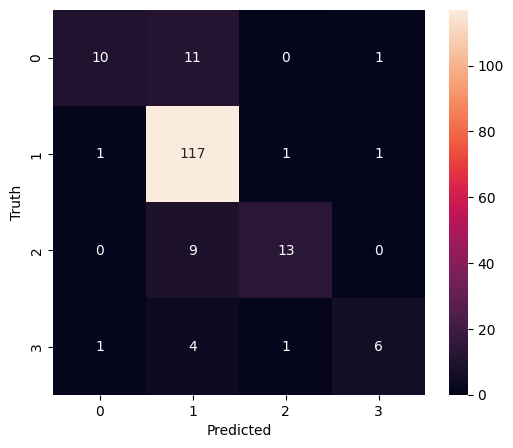

In [19]:
cm = confusion_matrix(y_test, y_predicted)

plt.figure(figsize = (6,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')